# SisFall

Data from: http://sistemic.udea.edu.co/en/investigacion/proyectos/english-falls/

In [30]:
# Import libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit

from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
# Recall should be the main evaluation metric!! Important to predict as many actual positives

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn import tree
from sklearn.linear_model import LogisticRegression

# Read Data

In [31]:
df = pd.read_csv('SisFall_Features.csv')
df.head()

,kurtosis_net_acceleration,max_net_acceleration,mean_net_acceleration,min_net_acceleration,skewness_net_acceleration,variance_net_acceleration,kurtosis_x_accel_g,max_x_accel_g,mean_x_accel_g,min_x_accel_g,...,skewness_z_rota,variance_z_rota,activity_type,subject_id,fall_bool,elderly_bool,Age,Height,Weight,male_bool
0,0.751145,1.988066,1.035022,0.573253,1.060546,0.044428,0.638710,0.548828,0.034781,-0.431641,...,-0.210259,667.002329,D01,SA01,False,False,26,165,53.0,False
1,1.330392,2.726306,1.069612,0.427002,1.098273,0.146066,-0.331147,0.865723,0.037700,-0.892578,...,-0.476083,1693.849892,D02,SA01,False,False,26,165,53.0,False
2,-1.270614,3.631156,1.211288,0.020916,0.227245,0.612209,0.936694,2.032715,0.043191,-1.951660,...,-0.029034,3495.929472,D03,SA01,False,False,26,165,53.0,False
3,-0.372966,4.791443,1.408362,0.028643,0.778544,0.885080,1.038636,2.694824,0.022865,-3.399414,...,-0.003143,5991.702127,D04,SA01,False,False,26,165,53.0,False
4,2.988875,1.983869,1.017596,0.619242,1.373114,0.029270,2.087312,0.389160,-0.015901,-0.684570,...,-0.144928,224.362448,D05,SA01,False,False,26,165,53.0,False


In [32]:
dropCols = ['elderly_bool','Age','activity_type','Height','Weight']

df.drop(dropCols,axis=1,inplace=True) # Should remove, high correlation with Age obviously

# EDA

In [33]:
df.head()

,kurtosis_net_acceleration,max_net_acceleration,mean_net_acceleration,min_net_acceleration,skewness_net_acceleration,variance_net_acceleration,kurtosis_x_accel_g,max_x_accel_g,mean_x_accel_g,min_x_accel_g,...,variance_z_accel_g,kurtosis_z_rota,max_z_rota,mean_z_rota,min_z_rota,skewness_z_rota,variance_z_rota,subject_id,fall_bool,male_bool
0,0.751145,1.988066,1.035022,0.573253,1.060546,0.044428,0.638710,0.548828,0.034781,-0.431641,...,0.035383,-0.245994,74.951172,-0.284954,-83.312988,-0.210259,667.002329,SA01,False,False
1,1.330392,2.726306,1.069612,0.427002,1.098273,0.146066,-0.331147,0.865723,0.037700,-0.892578,...,0.073199,0.243172,103.881836,-0.510623,-135.559082,-0.476083,1693.849892,SA01,False,False
2,-1.270614,3.631156,1.211288,0.020916,0.227245,0.612209,0.936694,2.032715,0.043191,-1.951660,...,0.193219,-1.139851,160.827637,-1.113962,-156.066895,-0.029034,3495.929472,SA01,False,False
3,-0.372966,4.791443,1.408362,0.028643,0.778544,0.885080,1.038636,2.694824,0.022865,-3.399414,...,0.183331,-0.996525,189.636230,-2.086868,-214.233398,-0.003143,5991.702127,SA01,False,False
4,2.988875,1.983869,1.017596,0.619242,1.373114,0.029270,2.087312,0.389160,-0.015901,-0.684570,...,0.015664,1.705028,66.650391,-0.151160,-72.326660,-0.144928,224.362448,SA01,False,False


In [34]:
# fall_forward = df[df['activity_type']=='F01']
# fall_backward = df[df['activity_type']=='F02']
fall_forward.describe()[['mean_x_accel_g','mean_y_accel_g','mean_z_accel_g',
                        'mean_x_rota','mean_y_rota','mean_z_rota']]

# z is vertical. Why is fall forward z-axis mean value negative that of fall backward??
# Accelero is on waist. Maybe when they fall backwards, it rises slightly?? TODO: Find someone who understands accelerometers

# Likely that fall forward vs fall backward can be identified by x_rota, unnecessary to create a feature to manually identify

,mean_x_accel_g,mean_y_accel_g,mean_z_accel_g,mean_x_rota,mean_y_rota,mean_z_rota
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,-0.042143,-0.375579,-0.452311,-4.966308,1.116981,0.135112
std,0.258229,0.140153,0.260680,2.480967,4.501649,1.987849
min,-0.580687,-0.766984,-0.833700,-10.180969,-11.087708,-5.849182
25%,-0.172550,-0.451463,-0.619934,-6.855052,-1.636556,-1.164164
50%,-0.034709,-0.381322,-0.522811,-5.307372,1.920745,-0.031331
75%,0.069228,-0.300570,-0.363473,-2.649717,3.926768,1.660268
max,0.652264,0.059835,0.485687,-0.288141,11.994202,4.335735


In [35]:
fall_backward.describe()[['mean_x_accel_g','mean_y_accel_g','mean_z_accel_g',
                        'mean_x_rota','mean_y_rota','mean_z_rota']]

,mean_x_accel_g,mean_y_accel_g,mean_z_accel_g,mean_x_rota,mean_y_rota,mean_z_rota
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,-0.025734,-0.512122,0.369814,4.840627,0.151567,0.199157
std,0.157148,0.118313,0.122827,2.782129,5.159261,2.179621
min,-0.514315,-0.967208,0.041466,-0.929362,-9.317444,-8.339335
25%,-0.078817,-0.601179,0.295732,2.640691,-4.064601,-0.812281
50%,-0.010770,-0.495696,0.351221,4.364665,-0.568878,0.405589
75%,0.029229,-0.426915,0.472314,7.379318,3.761007,1.261002
max,0.589067,-0.217421,0.597335,9.783325,12.172424,4.776978


### Threshold based trigger to begin ML calculation
(eg if 30g accel detected in y axis, trigger DT algorithm created below)

To prune out some false positives, and avoid having to run the ML algo 24/7

Tentatively, try:
- if x_accel > -0.04g
- if y_accel > -0.07g
- if z_accel > -0.55g

Alternatively, try:
- if x_accel > -0.82g
- if y_accel > -0.97g
- if z_accel > -0.9g

Not sure if first one is good enough to catch all falls. Bulk of the actual fall detection should be done by the decision tree

In [36]:
targetCol = ['max_x_accel_g','max_y_accel_g','max_z_accel_g',
            'mean_x_accel_g','mean_y_accel_g','mean_z_accel_g']

minVals = df.groupby('fall_bool')[targetCol].min().reset_index().add_prefix('MINVAL_')
# maxVals = df.groupby('fall_bool')[targetCol].max().reset_index().add_prefix('MAXVAL_')
minVals.loc[1]

MINVAL_fall_bool             True
MINVAL_max_x_accel_g    -0.037598
MINVAL_max_y_accel_g    -0.061035
MINVAL_max_z_accel_g    -0.523438
MINVAL_mean_x_accel_g    -0.81558
MINVAL_mean_y_accel_g   -0.967208
MINVAL_mean_z_accel_g   -0.899534
Name: 1, dtype: object

In [37]:
# df_falls = df[df['fall_bool']]

# # import matplotlib.pyplot as plt
# import seaborn as sns
# # sns.histplot(df[targetCol[0]])
# sns.violinplot(df_falls[targetCol[0]])

In [38]:
df.corr()['fall_bool'].sort_values(ascending=False)

fall_bool                    1.000000
skewness_net_acceleration    0.774927
max_net_acceleration         0.692379
mean_y_accel_g               0.691903
kurtosis_net_acceleration    0.687395
max_y_accel_g                0.631254
variance_z_accel_g           0.524233
max_z_rota                   0.516426
max_x_accel_g                0.502802
variance_y_accel_g           0.500148
kurtosis_z_rota              0.493795
variance_x_accel_g           0.490210
max_y_rota                   0.472603
kurtosis_x_rota              0.449272
max_z_accel_g                0.445391
kurtosis_y_rota              0.389861
max_x_rota                   0.349029
kurtosis_x_accel_g           0.306251
kurtosis_z_accel_g           0.187456
variance_net_acceleration    0.187336
variance_y_rota              0.146086
mean_z_rota                  0.101646
mean_net_acceleration        0.100825
skewness_z_rota              0.100187
skewness_z_accel_g           0.093078
variance_z_rota              0.085097
mean_z_accel

# Data preparation

In [39]:
# X = df.loc[:,df.columns != 'fall_bool']
# y = df['fall_bool']
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

# Ignore this cell, which does splitting randomly.

In [40]:
# Instead, should do train test split by subject id, to avoid data leakage
train_inds, test_inds = next(GroupShuffleSplit(test_size=.2, n_splits=2, random_state = 42).split(df, groups=df['subject_id']))

train = df.iloc[train_inds]
test = df.iloc[test_inds]

X_train = train.drop(['fall_bool','subject_id'],axis=1)
y_train = train['fall_bool']
X_test = test.drop(['fall_bool','subject_id'],axis=1)
y_test = test['fall_bool']

cols = X_train.columns

In [41]:
# scaler = StandardScaler().fit(X_train)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
# X_train = pd.DataFrame(X_train, columns = [cols])
# X_test = pd.DataFrame(X_test, columns = [cols])

# KNN

In [43]:
for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    print('n_neighbors = {0}: Model recall score: {1:0.7f}'. format(i,recall_score(y_test, y_pred)))

n_neighbors = 1: Model recall score: 0.9733333
n_neighbors = 2: Model recall score: 0.9555556
n_neighbors = 3: Model recall score: 0.9644444
n_neighbors = 4: Model recall score: 0.9600000
n_neighbors = 5: Model recall score: 0.9600000
n_neighbors = 6: Model recall score: 0.9600000
n_neighbors = 7: Model recall score: 0.9600000
n_neighbors = 8: Model recall score: 0.9600000
n_neighbors = 9: Model recall score: 0.9600000
n_neighbors = 10: Model recall score: 0.9600000
n_neighbors = 11: Model recall score: 0.9688889
n_neighbors = 12: Model recall score: 0.9644444
n_neighbors = 13: Model recall score: 0.9644444
n_neighbors = 14: Model recall score: 0.9600000


In [44]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[527   5]
 [  9 216]]


# SVM

In [45]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Recall:",recall_score(y_test, y_pred))

Recall: 0.9733333333333334


In [46]:
# TODO: Hyperparameter tuning. But SVM not good for our usecase, so skip if not planning to explore

# DT

In [47]:
# DT doesn't require scaling. Unscale, so output is interpretable

X_train = train.drop(['fall_bool','subject_id'],axis=1)
y_train = train['fall_bool']
X_test = test.drop(['fall_bool','subject_id'],axis=1)
y_test = test['fall_bool']

In [48]:
def feature_imp(model):
    a=dict(zip(cols, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

Best max_depth for gini: 16
Best max_depth for entropy: 16


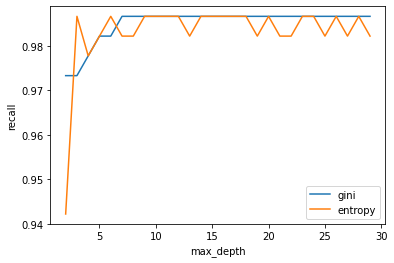

In [49]:
#We will attempt to prune the DecisionTree on the max_depth parameter, on both 'gini' and 'entropy' 

max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,30):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(recall_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(recall_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('recall')
plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [50]:
d # just pick max depth 6

,acc_gini,acc_entropy,max_depth
0,0.973333,0.942222,2
1,0.973333,0.986667,3
2,0.977778,0.977778,4
3,0.982222,0.982222,5
4,0.982222,0.986667,6
5,0.986667,0.982222,7
6,0.986667,0.982222,8
7,0.986667,0.986667,9
8,0.986667,0.986667,10
9,0.986667,0.986667,11


Best max_depth for gini: 29
Best max_depth for entropy: 29


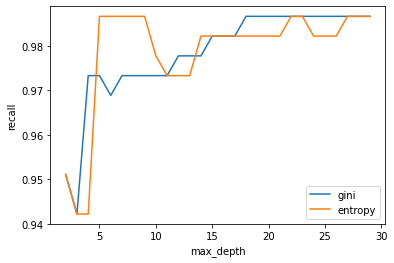

In [51]:
# !!! This is actually to tune max_leaf_nodes, just lazy change variable names

max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2,30):
    dtree = DecisionTreeClassifier(random_state=8,criterion='gini', max_leaf_nodes=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(recall_score(y_test, pred))
    ###
    dtree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(recall_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('recall')
plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

In [52]:
d # Just pick max leaf nodes 5

,acc_gini,acc_entropy,max_depth
0,0.951111,0.951111,2
1,0.942222,0.942222,3
2,0.973333,0.942222,4
3,0.973333,0.986667,5
4,0.968889,0.986667,6
5,0.973333,0.986667,7
6,0.973333,0.986667,8
7,0.973333,0.986667,9
8,0.973333,0.977778,10
9,0.973333,0.973333,11


In [53]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=42,max_depth=6,max_leaf_nodes=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [54]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))
print('Specificity:', round(specificity,4))
print('Sensitivity',round(recall_score(y_test,y_pred),4)) # Most impt metric is this (recall)
print('F1-Score:', round(f1_score(y_test,y_pred),4))
print('AUC:',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,525,6
Predicted Y=1,7,219


Accuracy: 0.9828
Specificity: 0.9868
Sensitivity 0.9733
F1-Score: 0.9712
AUC: 0.9801


[('skewness_net_acceleration', 0.7),
 ('mean_y_accel_g', 0.242),
 ('max_y_accel_g', 0.058)]

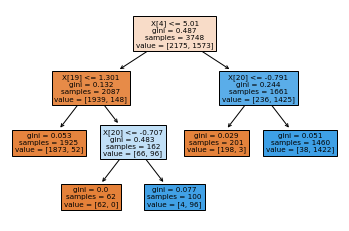

In [55]:
### Visualizing Decision Trees
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
plt.figure()
tree.plot_tree(clf,filled=True)  
plt.savefig('decisiontree.eps',format='eps',bbox_inches = "tight")
# Save as vector graphics (.eps)
# https://en.wikipedia.org/wiki/Vector_graphics

# We can see that if we do not restrict the parameters, overfitting can easily occur with large depth and high number of nodes

In [63]:
cols[20],cols[19],cols[4]

('mean_y_accel_g', 'max_y_accel_g', 'skewness_net_acceleration')

In [56]:
tree_rules = export_text(clf, feature_names=list(cols))
print(tree_rules)

|--- skewness_net_acceleration <= 5.01
|   |--- max_y_accel_g <= 1.30
|   |   |--- class: False
|   |--- max_y_accel_g >  1.30
|   |   |--- mean_y_accel_g <= -0.71
|   |   |   |--- class: False
|   |   |--- mean_y_accel_g >  -0.71
|   |   |   |--- class: True
|--- skewness_net_acceleration >  5.01
|   |--- mean_y_accel_g <= -0.79
|   |   |--- class: False
|   |--- mean_y_accel_g >  -0.79
|   |   |--- class: True



In [57]:
# To transcribe DT rules into a python function
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] 
                    if i != _tree.TREE_UNDEFINED else "undefined!" 
                    for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)
    
tree_to_code(clf,cols)

def tree(kurtosis_net_acceleration, max_net_acceleration, mean_net_acceleration, min_net_acceleration, skewness_net_acceleration, variance_net_acceleration, kurtosis_x_accel_g, max_x_accel_g, mean_x_accel_g, min_x_accel_g, skewness_x_accel_g, variance_x_accel_g, kurtosis_x_rota, max_x_rota, mean_x_rota, min_x_rota, skewness_x_rota, variance_x_rota, kurtosis_y_accel_g, max_y_accel_g, mean_y_accel_g, min_y_accel_g, skewness_y_accel_g, variance_y_accel_g, kurtosis_y_rota, max_y_rota, mean_y_rota, min_y_rota, skewness_y_rota, variance_y_rota, kurtosis_z_accel_g, max_z_accel_g, mean_z_accel_g, min_z_accel_g, skewness_z_accel_g, variance_z_accel_g, kurtosis_z_rota, max_z_rota, mean_z_rota, min_z_rota, skewness_z_rota, variance_z_rota, male_bool):
    if skewness_net_acceleration <= 5.010115385055542:
        if max_y_accel_g <= 1.301025390625:
            return 0
        else:  # if max_y_accel_g > 1.301025390625
            if mean_y_accel_g <= -0.707072913646698:
                return 0


In [58]:
# Can save this function on the Arduino

def tree(df):
    if df.skewness_net_acceleration <= 5.010115385055542:
        if df.max_y_accel_g <= 1.301025390625:
            return 0
        else:  # if max_y_accel_g > 1.301025390625
            if df.mean_y_accel_g <= -0.707072913646698:
                return 0
            else:  # if mean_y_accel_g > -0.707072913646698
                return 1
    else:  # if skewness_net_acceleration > 5.010115385055542
        if df.mean_y_accel_g <= -0.7913139462471008:
            return 0
        else:  # if mean_y_accel_g > -0.7913139462471008
            return 1
        
pred = test.apply(tree,axis=1)
confusion_matrix(pred, test.fall_bool)

array([[525,   6],
       [  7, 219]], dtype=int64)

Suggestion: Once event-trigger exceeds threshold at any point in time, DT code runs

- Pull 6 seconds of data pre-fall, and 6 post-fall
- Calculate net_acceleration
- Calculate skewness_net_acceleration, mean_y_accel_g

# LR

In [59]:
model = LogisticRegression()
model.fit(X_train,y_train)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [60]:
y_pred = model.predict(X_test)
recall_score(y_test,y_pred)

0.9377777777777778